<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week_4/SanneAartsML2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### To whomever is reading this, I apologise for the incompleteness of this Code, I got much too excited, as you may be able to tell and was not able to produce a complete product

In [1]:
%pip install keras
%pip install keras-tuner
%pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=8ef6e8ec7da3804cae524063af5e642c77ce48ede56a8b9ea856bc53e0e4f34b
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


## The cartPole
### Action space
<ul>
<li>push left - 0</li>
<li>push right - 1</li>
</ul>

### Observation space
|num|Observation|Variable|Values|Episode terminates for:|
|-|-|-|-|-|
|0|Cart position|$x$|$\pm$ 4.8|$\lvert x \rvert > 2.4$|
|1|Cart Velocity|$\dot{x}$|$\pm \infty$||
|2|Pole Angle|$\theta$|$\pm$ 24 $^ \circ$|$\lvert \theta \rvert > 12 ^\circ $|
|3|Pole Angular Velocity|$\dot{\theta}$|$\pm\infty$||


In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras.losses import Huber
from keras_tuner import HyperParameters
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import datetime

<ipython-input-2-ee689b96a17f>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


#### Bellman Equation
At some time t, the expected return from an action a, taken from a starting state s, via some optimal policy, is given by the expected reward $R_{t+1}$
\begin{equation}
\begin{array}{cc}
Q_{new}(s, a)&=Q(s,a)+\alpha \left[ r(s,a)+ \gamma * max_{a'}(Q'(s',a'))-Q(s,a)\right]\\
\\
\text{                    }&=Q(s,a)\left(1-\alpha\right)+ \alpha \left[ r(s,a)+\gamma* max_{a'}(Q'(s',a'))\right] 
\end{array} \hspace{1em}
\begin{array}{rl}
Q_{new}:& \text{New Q value}\\
Q:& \text{Current Q value}\\
s:& \text{State}\\
a:& \text{Action}\\
\alpha:& \text{Learning Rate}\\
r:& \text{reward}\\
\gamma:& \text{Discount rate}\\
max(Q'(s',a')):& \text{Maximum expected future reward}\\
\end{array} 
\tag{1}
\end{equation}

The discount factor $\gamma$ ensures that the agent focusses on immediate rewards over future rewards, a lower value means more short term decisions. 

##### State value 
The expected total reward we can get being in a specific state
$$V^{\pi}(s)=\mathbb{E}\left[R_t | s_t = s\right]$$
##### Value function
The expected total reward we can get by performing some action starting from a state
$$Q^{\pi}(s,a)=\mathbb{E}\left[R_t | s_t = s, a_t=a\right]$$
#### Greedy Policy
A greedy policy is a policy where you always choose the most beneficial next step, 
in this case:
$$V(s_t)=max Q(s_t,a)$$
#### Loss function

\begin{equation}
L=\frac{1}{2}\left[r+\gamma max_{a'}(Q'(s',a'))-Q(s,a) \right]^2 
\tag{2}
\end{equation}

In [ ]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space

In [ ]:
class DQNagent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)

        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_rate_decay = 0.995
        self.exploration_rate_min = 0.01
        self.learning_rate = 0.001
        
        
        self.model = self.build_model('relu', Huber())
        self.target = self.build_model('relu', Huber())
        self.target.set_weights(self.model.get_weights())
        self.counter = 0
        self.c = 350

        self.loss = []
        self.rewards = []
        self.qvalues = []
        self.exploration_rates =[]
        
    def build_model(self,activation,loss):
      # Building Network
      # Create a Sequential model using keras
      model = Sequential()
      #Input - 4 different states 
      model.add(Flatten(input_shape = (self.state_size,)))
      model.add(Dense(24, activation=activation))
      model.add(Dense(24, activation=activation))
      
      # Output - one node for each possible action (2), the one with the 
      # highest output value will be be returned as action
      model.add(Dense(self.action_size))
      model.compile(loss=loss, optimizer=Adam(lr=self.learning_rate))
      model.summary()
      return model
                 
    
        
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
        # than the exploration rate,a random action is selected from the available actions
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        # otherwise the action with the highest predicted Q-value is selected 
        # state is passed into the predict method to get the predicted Q value for
        # all possible actions (here, to go left or right)
        act_values = self.model.predict(state)
        # since we get two outputs, we want to select the action corresponding to the highest value
        return np.argmax(act_values[0])
    
    def decay_exploration(self):
        # As our model gets more experience, we want it to make more informed choices by using that experience, 
        # So while looping through different episodes we slowly decrease the exploration rate, since we don't want it to
        # go to 0 completely, we require that it remains above some previously defined minimum
        if self.exploration_rate > self.exploration_rate_min:
            self.exploration_rate *= self.exploration_rate_decay
            self.exploration_rates.append(self.exploration_rate)

    def train(self, batch_size):
        if len(self.memory)< batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            q_future = reward
            if not done:
                q_future = (reward + self.gamma * np.amax(self.target.predict(next_state)[0]))
            qvalues = self.model.predict(state)
            qvalues[0]=q_future
            self.qvalues.append(qvalues)
            self.rewards.append(reward)
            loss = self.model.fit(state,qvalues, batch_size=batch_size)
            self.loss.append(loss.history['loss'][0])
            if done:
                self.counter+=1

            if self.counter > self.c:
                self.target.set_weights(self.model.get_weights())
                self.counter = 0

            self.decay_exploration()
    
    def plot_loss(self):
        # plot training loss over time
        plt.figure(figsize=(12,6))
        plt.plot(self.loss)
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Training Steps')
        plt.show()
    
    def plot_reward(self):
        # plot rewards over time
        plt.figure(figsize=(12,6))
        plt.plot(self.rewards[0], label ="score")
        plt.plot(self.qvalues[0], label ="Q-Values")
        plt.axhline(500)
        plt.title('Model Rewards')
        plt.ylabel('Reward')
        plt.xlabel('Episode')
        plt.show()

    def plot_exploration(self):
        # plot exploration rates over time
        plt.figure(figsize=(12,6))
        plt.plot(self.exploration_rates)
        plt.axhline(self.exploration_rate_min)
        plt.title('Exploration Rate of model')
        plt.ylabel('Exploration rate')
        plt.xlabel('Episode')
        plt.show()

    def save(self):
        self.model.save_weights('dqn_weights.h5f', overwrite=True)
        # self.model.save_weights(name)
    
    def test(self,test_episodes = 100):
        env_test = gym.make('CartPole-v1')

        # Load the saved model weights
        model = Sequential([
            Dense(32, activation='relu', input_dim=env_test.observation_space.shape[0]),
            Dense(32, activation='relu'),
            Dense(env_test.action_space.n, activation=None)
        ])
        model.load_weights('dqn_weights.h5f')

        # Set the epsilon value to zero for testing
        explorationrate  = 0.0001

        # Run the test loop for 10 episodes
        test_episodes = 10
        test_rewards = []
        for i in range(test_episodes):
            state = env_test.reset()
            done = False
            ep_reward = 0
            while not done:
                # Use the learned policy to select actions
                q_values = model.predict(np.array([state]))[0]
                action = np.argmax(q_values)
                # Take the action and observe the new state and reward
                state, reward, done, _ = env_test.step(action)
                # Update the episode reward
                ep_reward += reward
            # Append the episode reward to the list of test rewards
            test_rewards.append(ep_reward)

        # Print the average reward obtained over all test episodes
        plt.plot(range(test_episodes), test_rewards)
        plt.axhline(sum(test_rewards)/len(test_rewards))
    



In [ ]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

from keras.utils.vis_utils import plot_model
def build_model(hp):
    
    # Building Network
    # Create a Sequential model using keras
    model = Sequential()
    # model.add(layers.Flatten())
    #Input - 4 different states 
    #We define the exploration rate as a continuous range of variables
    model.add(Flatten(input_shape=(state_size,)))
    # model.add(Dense(
    #     units=hp.Float('exploration_rate', min_value=0.01, max_value=1.0, sampling='log'),
    #     activation= hp.Choice('activation', ['relu', 'softmax']) ))
    # # Add hidden layers
    # We define gamma and the learning rate as discrete variables
    learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    model.add(Dense(input_shape=(state_size, ),
        units=hp.Choice('gamma', values=[0.6,0.7,0.8,0.9,0.99]),
        activation= 'relu' ))
    
    model.add(Dense(24,
        units=learning_rate,
        activation='relu'))
    # Output - one node for each possible action (2), the one with the 
    # highest output value will be be returned as action, 
    model.add(Dense(action_size))
    
    # Compile the model
    model.compile(
        optimizer = Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

def dataHandeling():
    rewards_history =[]
    agent = DQNagent(state_size,action_size)
    num=200
    x = np.zeros((num,4))
    y = np.zeros((num,2))
    for episode in range(num):
      state=env.reset()
      done = False
      episode_reward = 0
      while not done:
        action = agent.act(state)
        next_state, reward, done,_ = env.step(action)
        reward = reward if not done else - reward
        rewards_history.append(reward)
        episode_reward += reward
        x[episode] = state
        y[episode][action] = reward
        state = next_state
        if done:
          break
    xtrain, xval, ytrain, yval = train_test_split(x,y, test_size=0.4,random_state=42)
    return xtrain, xval, ytrain, yval 


def Optimal_model():
    hp = HyperParameters()
    xtrain, xval, ytrain, yval = dataHandeling()
    tuner = RandomSearch(build_model,
                      objective='val_accuracy',
                      max_trials=1,
                      executions_per_trial=1,
                      overwrite=True,
                      directory='cartpole_logs',
                      project_name='cartpole')
    tuner.search(xtrain, ytrain, epochs=1, validation_data=(xval,yval))
    bestparams = tuner.get_best_hyperparameters(2)
    model = build_model(bestparams[0])
    return {'params':bestparams[0],"model": model}



/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
Optimal_model()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 4)                 0         
                                                                 
 dense_36 (Dense)            (None, 24)                120       
                                                                 
 dense_37 (Dense)            (None, 24)                600       
                                                                 
 dense_38 (Dense)            (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (No

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/metrics_tracking.py:345: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  in inspect.getargspec(keras.metrics.deserialize).args


TypeError: ignored

In [ ]:
a

<function __main__.Optimal_model()>

In [ ]:
class Model:
      
  def __init__(self):
      params, self.model = a["params"], a["model"]
      # self.model = build_model(params)
      self.memory = deque(maxlen=10000)
      self.loss = []
      self.rewards = []
      self.qvalues = []
      self.exploration_rates =[]
      self.exploration_rate = 1.0
      self.exploration_rate_decay = 0.995
      self.exploration_rate_min = 0.01
      self.gamma = params.values["gamma"]
      self.learning_rate = params.values["learning_rate"]


      self.state_space = env.observation_space.shape[0]
      self.action_space = env.action_space.n

  def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
    

  def train(self, batch_size):
      # xtrain, xval, ytrain, yval = 
      # x = np.zeros((batch_size,4))
      # y = np.zeros((batch_size,2))
      if len(self.memory) < batch_size:
          return
      elif len(self.memory) < 4*batch_size:
          minibatch = random.sample(self.memory, batch_size)
          for index, (state, action, reward, next_state, done) in enumerate(minibatch):
              q_future = reward
              
              if not done:
                  q_future = (reward + self.gamma * np.amax(self.model.predict(next_state)))

              qvalue = self.model.predict(state)
              qvalue[0][action]=q_future

              qvalue_train, qvalue_val, state_train , state_val = train_test_split(qvalue, state, test_size=0.5, random_state=42)
              self.model.fit(state_train, qvalue_train, batch_size=0.5*batch_size, validation_data=(qvalue_val, state_val), validation_batch_size=0.5*batch_size )
          return 
      # We take a random subset from the memory to learn from, it is important that it is random, sequential
      # runs are likely to be similar during later episodes 
      minibatch = random.sample(self.memory, 4*batch_size)
      for index, (state, action, reward, next_state, done) in enumerate(minibatch):
          q_future = reward
          
          if not done:
              q_future = (reward + self.gamma * np.amax(self.model.predict(next_state)))

          qvalue = self.model.predict(state)
          qvalue[0][action]=q_future

          qvalue_train, qvalue_val, state_train , state_val = train_test_split(qvalue, state, test_size=0.25, random_state=42)
          self.model.fit(state_train, qvalue_train, batch_size=batch_size, validation_data=(qvalue_val, state_val), validation_batch_size=3*batch_size )
    
  def act(self, state):
      # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
      # than the exploration rate,a random action is selected from the available actions
      if np.random.rand() <= self.exploration_rate:
          return random.randrange(self.action_space)
      # otherwise the action with the highest predicted Q-value is selected 
      # state is passed into the predict method to get the predicted Q value for
      # all possible actions (here, to go left or right)
      act_values = self.model.predict(state)
      # since we get two outputs, we want to select the action corresponding to the highest value
      return np.argmax(act_values[0])

  def decay_exploration(self):
        # As our model gets more experience, we want it to make more informed choices by using that experience, 
        # So while looping through different episodes we slowly decrease the exploration rate, since we don't want it to
        # go to 0 completely, we require that it remains above some previously defined minimum
        if self.exploration_rate > self.exploration_rate_min:
            self.exploration_rate *= self.exploration_rate_decay
     

  def test(self):
    return

In [ ]:
def cartpole():
  agent = Model()
  episodes = 200
  batch_size = 1
  rewards_history =[]
    
  for episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1,state_size])
    done = False
    episode_reward = 0
    while not done:
      action = agent.act(state)
      next_state, reward, done,_ = env.step(action)
      reward = reward if not done else - reward
      agent.remember(state, action, reward, next_state, done)
      episode_reward += reward
      state = next_state
      if len(agent.memory) > batch_size:
          agent.train(batch_size)
      if done:
          print("episode: {}/{}, score: {}, e: {:.2}".format(episode, episodes, score, agent.exploration_rate))
          rewards_history.append(episode_reward)      
      break
      plt.plot(rewards_history)

In [ ]:
cartpole()

TypeError: ignored

In [ ]:
def cartpole():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNagent(state_size,action_size)
    episodes = 5
    batch_size=2
    episode_rewards = deque(maxlen=1000) 
    exp = agent.exploration_rate
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1,state_size])
        score = 0
        done = False
        while done != True:
            # steps += 1
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            reward = reward if not done else - reward
            next_state = np.reshape(next_state, [1,state_size])
            # self.agent.decay_exploration()
            agent.remember(state, action, reward, next_state, done)
            score += reward
            episode_rewards.append(score)
            
            if len(agent.memory) > batch_size:
                agent.train(batch_size)
                
            if done:
                
                break
    env.close()       
    agent.plot_exploration() 
            

    # plt.plot(self.agent.exploration_rate)
    # fig, axs = plt.subplots(2,2)

    # axs[0,0].plot(episode_rewards)
    # axs[0,1].plot(agent.exploration_rate)
    # axs[1,0].plot(agent.loss)
    # axs[1,1].plot(agent.trainingtime)
    # plt.ylabel("# actions before terminal")
    # plt.xlabel("run iteration")

def test(self):
    self.agent.test()
#     success_measure = np.mean(runsteplog[-15:])
#     print("Mean of last 15 runs: {0}".format(success_measure))
    
#     agent.save("weights")

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 4)                 0         
                                                                 
 dense_108 (Dense)           (None, 24)                120       
                                                                 
 dense_109 (Dense)           (None, 24)                600       
                                                                 
 dense_110 (Dense)           (None, 1)                 25        
                                                                 
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (No

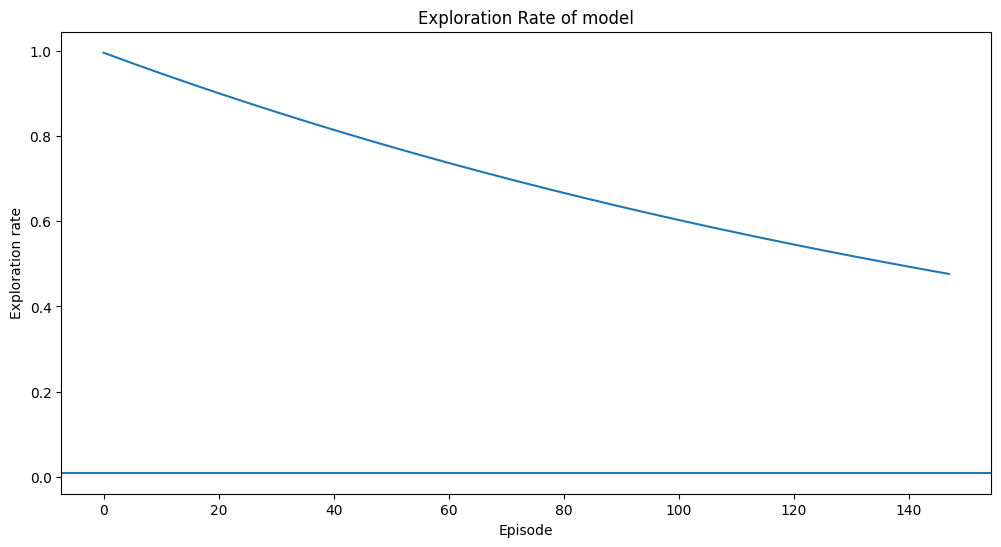

In [ ]:
cartpole()

In [ ]:
# class DQNagent:
#     def __init__(self, state_size, action_size):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.memory = deque(maxlen=100000)

#         self.gamma = 0.95
#         self.exploration_rate = 1.0
#         self.exploration_rate_decay = 0.995
#         self.exploration_rate_min = 0.01
#         self.learning_rate = 0.001
        
        
#         self.model = self.build_model('relu', 'mse')
#         self.target = self.build_model('relu', 'mse')
#         self.target.set_weights(self.model.get_weights())
#         self.counter = 0
#         self.c = 350
#         self.loss = []
#         self.trainingtime = []
#         self.hp = keras_tuner.HyperParameters()
#     def build_model(self, activation, loss):
#         # Building Network
#         # Create a Sequential model using keras
#         model = Sequential()
#         #Input - 4 different states 
#         # model.add(Flatten(input_shape=(1,self.state_size)))
#         model.add(Flatten(input_shape = (self.state_size,)))
#         model.add(Dense(24, activation=activation))
#         model.add(Dense(24, activation=activation))
        
#         # Output - one node for each possible action (2), the one with the 
#         # highest output value will be be returned as action
#         model.add(Dense(self.action_size))
#         model.compile(loss=loss, optimizer=Adam(lr=self.learning_rate))
#         model.summary()
#         return model
        
#     def remember(self, state, action, reward, next_state, done): 
#         self.memory.append((state, action, reward, next_state, done))
    
#     def act(self, state):
#         # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
#         # than the exploration rate,a random action is selected from the available actions
#         if np.random.rand() <= self.exploration_rate:
#             return random.randrange(self.action_size)
#         # otherwise the action with the highest predicted Q-value is selected 
#         # state is passed into the predict method to get the predicted Q value for
#         # all possible actions (here, to go left or right)
#         act_values = self.model.predict(state)
#         # since we get two outputs, we want to select the action corresponding to the highest value
#         return np.argmax(act_values[0])
    
#     def decay_exploration(self):
#         # As our model gets more experience, we want it to make more informed choices by using that experience, 
#         # So while looping through different episodes we slowly decrease the exploration rate, since we don't want it to
#         # go to 0 completely, we require that it remains above some previously defined minimum
#         if self.exploration_rate > self.exploration_rate_min:
#             self.exploration_rate *= self.exploration_rate_decay
    
#     def train(self, batch_size):
#         if len(self.memory)>= batch_size:
#             minibatch = random.sample(self.memory, batch_size)
#             for index, (state, action, reward, next_state, done) in enumerate(minibatch):
#                 qvalue = self.model.predict(state)
#                 q_future = self.target.predict(next_state)
#                 # q_future = self.target.predict(next_state)[0]
#                 if done == True:
#                     target = reward
#                 else:
#                     target = reward + self.gamma * np.max(q_future)
                
#                 qvalue[0][action]=target
                
#             # x,y = np.array(x).reshape(1, self.state_size), np.array(y).reshape(1, batch_size, 1, self.action_size)
#             # l = max(len(x),len(y))
#             # x.resize(l), y.resize(l)
#                 loss = self.model.fit(state,qvalue, batch_size=batch_size)
#                 self.loss.append(loss.history['loss'][0])
#                 if done:
#                     self.counter+=1

#                 if self.counter > self.c:
#                     self.target.set_weights(self.model.get_weights())
#                     self.counter = 0
#     # def replay(self, batch_size, episode):
#     #     # Once there are enough experiences in the memory to work with, 
#     #     if len(self.memory) < batch_size:
#     #         return
#     #     # We take a random subset from the memory to learn from, it is important that it is random, sequential
#     #     # runs are likely to be similar during later episodes 
#     #     minibatch = random.sample(self.memory, batch_size)
#     #     # For every collection of observables in he minibatch we calculate 
#     #     for state, action, reward, next_state, terminal in minibatch:
#     #         q_update = reward
            
#     #         if not terminal:
#     #             q_update = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            
#     #         q_value = self.model.predict(state)
#     #         q_value[0][action] = q_update
#     #         history = self.model.fit(state, q_value, epochs=1, verbose=0)
#     #         self.loss.append(history.history["loss"])
#     #         self.trainingtime.append(history.history['loss'])
        

    
#     def save(self):
#         self.model.save_weights('dqn_weights.h5f', overwrite=True)
#         # self.model.save_weights(name)
    
#     def test(self,test_episodes = 100):
#         env_test = gym.make('CartPole-v1')

#         # Load the saved model weights
#         model = Sequential([
#             Dense(32, activation='relu', input_dim=env_test.observation_space.shape[0]),
#             Dense(32, activation='relu'),
#             Dense(env_test.action_space.n, activation=None)
#         ])
#         model.load_weights('dqn_weights.h5f')

#         # Set the epsilon value to zero for testing
#         explorationrate  = 0.0001

#         # Run the test loop for 10 episodes
#         test_episodes = 10
#         test_rewards = []
#         for i in range(test_episodes):
#             state = env_test.reset()
#             done = False
#             ep_reward = 0
#             while not done:
#                 # Use the learned policy to select actions
#                 q_values = model.predict(np.array([state]))[0]
#                 action = np.argmax(q_values)
#                 # Take the action and observe the new state and reward
#                 state, reward, done, _ = env_test.step(action)
#                 # Update the episode reward
#                 ep_reward += reward
#             # Append the episode reward to the list of test rewards
#             test_rewards.append(ep_reward)

#         # Print the average reward obtained over all test episodes
#         plt.plot(range(test_episodes), test_rewards)
#         plt.axhline(sum(test_rewards)/len(test_rewards))
    



## Agent

$$loss=\left(r+\gamma max \hat{Q}(s,a')-Q(s,a\right)^2$$

In [ ]:
#create a vector of randomly generated parameter in the range [-1,1]
parameters = np.random.rand(4)*2-1

In [ ]:
def run_episode(env, parameters):
    state = env.reset()
    totalreward = 0
    for _ in range(500):
        action = 0 if np.matmul(parameters, state) < 0 else 1
        state, reward, done, _ = env.step(action)
        reward = reward if not done else - reward
        totalreward += reward
        if done:
            break
    return totalreward

In [ ]:
bestparams = None
bestreward = 0
env = gym.make('CartPole-v1')
for _ in range(10000):
    parameters = np.random.rand(4) * 2 - 1
    reward = run_episode(env,parameters)
    if reward > bestreward:
        bestreward = reward
        bestparams = parameters
        # considered solved if the agent lasts 200 timesteps
        if reward == 500:
            break
    print(bestparams)

[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[ 0.98154411 -0.09250534 -0.0068868   0.89230561]
[-0.21643228 -0.00933613  0.21403858  0.83584804]
[-0.21643228 -0.00933613  0.21403858  0.83584804]
[-0.21643228 -0.00933613  0.21403858  0.83584804]
[-0.21643228 -0.00933613  0.21403858  0.83584804]
[0.1355736  0.41995759 0.81964266 0.39888624]
[0.1355736  0.41995759 0.81964266 0.39888624]
[0.1355736  0.41995759 0.81964266 0.39888624]
[0.1355736  0.41995759 0.81964266 0.39888624]
[0.1355736  0.41995759 0.81964266 0.39888624]
[0.1355736  0.41995759 0.81964266 0.39888624]
[0.1355736  0.41995759 0